# Descrição do problema

In [ ]:
# assistir o video de introdução para descrever as tarefas tirar print de um .json

## Instalação e carregamento das Bibliotecas

In [2]:
#### instalação das bibliotecas - Se necessário
#pip install spacy
#pip install scispacy
#pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_core_sci_md-0.2.5.tar.gz

In [1]:
import numpy as np
import zipfile
import pandas as pd
import glob
import json
import seaborn as sns
import spacy
import nltk
import scispacy
from matplotlib import pyplot as plt
import en_core_sci_md 

## Carregamento da Base de dados
Nesse caso inicialmente será criado um dicionário vazio, que será utilizado para buscar na base de dados os seguintes atributos nos artigos:
* a identificação (paper_id);
* o título (title)
* o resumo (abstract)
* o corpo (text)

In [2]:
### dicionário
dicArtigos = {'paper_id':[], 'title':[],
             'abstract':[], 'text':[]}
type(dicArtigos)

dict

Posteriormente o dicionário é transformado em dataframe, para facilitar a manipulação no decorrer do processamento.

In [3]:
## transformando em dataframe
dfArtigos = pd.DataFrame.from_dict(dicArtigos)
type(dfArtigos)

pandas.core.frame.DataFrame

Criada a estrutura, será feita uma busca recursiva pelos arquivos .json presentes no diretório.

In [15]:
## com o auxilio da blibioteca de leitura de diretorio será
## lido o arquivo json, coletado o nome dos artigos e preennchido

listaArtigos = glob.glob(f'{"./"}//**/*.json', recursive= True) 

print('Foram encontrados ',len(listaArtigos), ' artigos') # total de artigos percorrido

Foram encontrados  29315 artigos


A seguir será criada a função que de fato alimentará o dataframe com os atributos definidos anteriormente.

In [17]:
## funcao que vai percorrer todos os aquivos e pupilar o DF
def funcao_dfArtigos(listaArtigos, df):
    for nomeArtigo in listaArtigos:
        linhaDF={'paper_id':None, 'title':None,
                 'abstract':None, 'text':None}
        
        with open(nomeArtigo) as json_data:
            
            dados = json.load(json_data)
            
            linhaDF['paper_id']=dados['paper_id'].strip() #retirando os espaços no inicio e no fim
            linhaDF['title']=dados['metadata']['title'] # há uma tag a mais mostrar a estrutura da base
            # extração palavra por palavra do abstract
            listaAbstract = [abstract['text'] for abstract in dados['abstract']]
            abstract = '\n'.join(listaAbstract)# unindo
            linhaDF['abstract']=abstract.strip()
            # extração palavra por palavra do conteudo
            listaTexto = [text['text'] for text in dados['body_text']] # unindo
            texto = '\n'.join(listaTexto)
            linhaDF['text']=texto.strip()
            
            df = df.append(linhaDF, ignore_index = True)
        
    return df
    

Agora a função criada será chamada e de fato ocorrerá a extração dos dados e insersão no dataframe.

Observação: Este procedimento demora alguns minutos.


In [18]:
dfArtigos = funcao_dfArtigos(listaArtigos, dfArtigos)

In [19]:
print('O dataframe foi alimentado com ',dfArtigos.shape[0], ' artigos e ', dfArtigos.shape[1], ' atributos')

O dataframe foi alimentado com  87945  artigos e  4  atributos


Visualizando os primeiros registros do dataframe

In [20]:
dfArtigos.head()

,paper_id,title,abstract,text
0,c79f73c69108533aa867037948f63229d877e9fd,,,Fatty acids are covalently attached to many me...
1,90d1d04a22ec4e9f4e1e0d63053a99784ca489d6,Equine sarcoid: In situ demonstration of matri...,Sarcoids are the most prevalent equine skin tu...,Sarcoids are the most common equine skin tumou...
2,0a9145664ca5e8dd902b5f01f70a53e638ab52a9,Evaluation of a single-tube fluorogenic RT-PCR...,Bovine respiratory syncytial virus (BRSV) caus...,"Bovine respiratory syncytial virus (BRSV), a P..."
3,4564577ec73f757cb36aae29fd4c867482f84dee,Evidence and future potential of mobile phone ...,Global health threats such as the recent Ebola...,Novel sources of data coupled with new data mi...
4,bc9e8da285ed2401fb1351f9edd7891385524c31,Brown,This chapter describes how the impact of psych...,"This is an adaptive response in one sense, pro..."


Verificando se o conteúdo do artigo foi carregado

In [22]:
# verificando o conteúdo do primeiro artigo do dataframe
len(dfArtigos['text'][0])

13775

## Pré Processamento da Base de dados

Inicialmente será verificado no dataframe se há valores faltantes, ou seja, se no dataframe os artigos foram  alimentado com todos os atributos definidos no dicionário. 

Então, por se tratar de uma base de dados textual será será feito um mapa de calor com o auxilio da biblioteca seaborn. A intenção é visualmente saber em quais artigos há atributos faltantes.

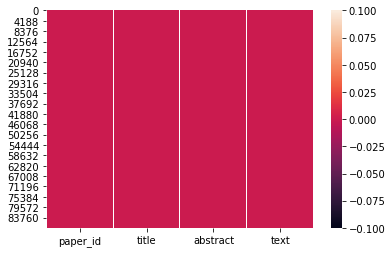

In [24]:
sns.heatmap(dfArtigos.isnull());

De acordo com o mapa de calor, em todos os artigos foram carregadas alguma informação em cada atributo, seja informação útil ou apenas um espaço. No entanto, conforme é possível notar no head do dataframe, há artigos sem título ou sem ID. Dessa forma será verificado em todas as colunas do dataframe se há algum atributo com apenas um espaço, ou seja ''

In [29]:
# verificando se há artigo sem ID
print ('Foram encontrados ',len(dfArtigos[dfArtigos['paper_id']=='']), 'artigos sem o ID')

Foram encontrados  0 artigos sem o ID


In [30]:
print ('Foram encontrados ',len(dfArtigos[dfArtigos['title']=='']),'artigos sem o título')

Foram encontrados  10749 artigos sem o título


In [32]:
print ('Foram encontrados ',len(dfArtigos[dfArtigos['abstract']=='']), 'artigos sem o resumo')

Foram encontrados  24153 artigos sem o resumo


In [33]:
print ('Foram encontrados ',len(dfArtigos[dfArtigos['text']=='']),'artigos sem conteúdo')

Foram encontrados  0 artigos sem conteúdo


Feita as verificações, será excluído da base de dados os artigos com informações faltantes

In [35]:
totalArtigos=dfArtigos.shape[0]
totalArtigos

87945

In [39]:
## apagando os artigos que faltam informações
dfArtigos = dfArtigos[dfArtigos['title'] != ''] # deixando somente os artigos que tem titulo

In [40]:
dfArtigos = dfArtigos[dfArtigos['abstract'] != ''] # deixando somente os artigos que tem abstract

In [41]:
print('Haviam ', totalArtigos,'após a limpeza ficaram, ', dfArtigos.shape[0],'artigos')

Haviam  87945 após a limpeza ficaram,  61029 artigos


Por fim, usando uma função do pandas, será removido os artigos que estejam duplicados no dataframe.

In [43]:
# remoção de artigos duplicados, o inplace = true remove e atualiza o df
dfArtigos.drop_duplicates(['abstract','text','title'], inplace=True)

In [50]:
print('Após todo o préprossecamento restaram ', dfArtigos.shape[0],'artigo')
print('Uma redução de',round(100-dfArtigos.shape[0]*100/totalArtigos), '% da base de dados')

Após todo o préprossecamento restaram  20211 artigo
Uma redução de 77 % da base de dados


In [ ]:
# retirando uma amostra da base de dados, trabalhando com uma amostra de 500 registros
